In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the datasets

In [2]:
# Two of of the files are delimited by comma and two by semicolon. Also use the latin1 encoding for the special characters 
# that appear in names

pesticides = pd.read_csv('../data/pesticides_usage.csv',encoding='latin1',delimiter=';', on_bad_lines='warn')
temperature = pd.read_csv('../data/temperature.csv',encoding='latin1', delimiter=',',on_bad_lines='warn')
yields = pd.read_csv('../data/yield.csv', encoding='latin1', delimiter=';',on_bad_lines='warn')


Special process for rain dataset.

In [3]:
rain_data = []

# Open the file manually and process line by line
with open('../data/rain.csv', 'r') as f:
    for line in f:
        try:
            # Split line into columns and check if it's valid
            row = line.strip().split(',')
            if len(row) != 3:
                row = [row[0] +" "+ row[1], row[2], row[3]]
                rain_data.append(row)
            rain_data.append(row)
        except Exception as e:
            print(f"Error processing row: {e}")

rain = pd.DataFrame(rain_data, columns=['country', 'year', 'average_rain_fall_mm_per_year'])
rain.drop(0,inplace=True)

# Exploration

## Rain

For the rain dataset, we have the average rainfall recieved in all the years from 1985-2017

In [4]:
rain.year.unique()

array(['1985', '1986', '1987', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype=object)

In [5]:
rain.describe()

,country,year,average_rain_fall_mm_per_year
count,6882,6882,6882
unique,217,31,174
top,Congo Dem. Rep.,1985,
freq,62,222,836


In [6]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6882 entries, 1 to 6882
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   country                        6882 non-null   object
 1   year                           6882 non-null   object
 2   average_rain_fall_mm_per_year  6882 non-null   object
dtypes: object(3)
memory usage: 161.4+ KB


In [7]:
# Converting erroneous values to np.NaN and converting the values to float for calculations
rain.loc[rain.average_rain_fall_mm_per_year == '', 'average_rain_fall_mm_per_year'] = np.NaN
rain.loc[rain.average_rain_fall_mm_per_year == '..', 'average_rain_fall_mm_per_year'] = np.NaN
rain.loc[rain.average_rain_fall_mm_per_year == 'NaN', 'average_rain_fall_mm_per_year'] = np.NaN
rain['average_rain_fall_mm_per_year'] = rain['average_rain_fall_mm_per_year'].astype('float')

In [8]:
# This is the average rainfall in all the years in a particular country
country_rain = rain.groupby('country')['average_rain_fall_mm_per_year'].mean()

In [9]:
# This is the global average rainfall per year
global_rain = rain.groupby(['year'])['average_rain_fall_mm_per_year'].mean()

### PCA

In [10]:
rain.dropna(inplace=True)
rain_pivot = pd.pivot_table(rain, values = 'average_rain_fall_mm_per_year', columns = 'year', index = 'country')
rain_pivot.fillna(0, inplace = True)

# Scale the data to have zero mean and unit variance (important for PCA)
scaler = StandardScaler()

# get numeric data
num_d = rain_pivot.select_dtypes(exclude=['object'])

# update the cols with their normalized values
rain_pivot[num_d.columns] = scaler.fit_transform(num_d)


In [11]:

# Apply PCA with the number of components specified (e.g., 2 or 3 for visualization)
pca = PCA(n_components=2)  # You can also set n_components to a float (e.g., 0.95) for explained variance ratio
principal_components = pca.fit_transform(rain_pivot[num_d.columns])

# Convert the principal components to a DataFrame for analysis
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

# Display the first few rows of the PCA-transformed data
print(df_pca.head())

df_pca['country'] = list(rain_pivot.index)

        PC1       PC2
0 -5.640639 -0.004838
1  2.557049 -0.002451
2 -7.325484 -0.005329
3 -0.805561 -0.003430
4 -0.805561 -0.003430


In [12]:
# We can identify the variation of water through the years and how the 
# different countries behave through pca.

In [13]:
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# To get the cumulative variance explained by the components
cumulative_variance = np.cumsum(explained_variance)
print("Cumulative Variance:", cumulative_variance)


Explained Variance Ratio: [0.99676215 0.00224386]
Cumulative Variance: [0.99676215 0.99900601]


In [14]:
# Get the loadings (contributions of each feature to the principal components)
loadings = pca.components_

# Convert to a DataFrame with feature names
df_loadings = pd.DataFrame(loadings, columns=rain_pivot.columns, index=['PC1', 'PC2'])

print("Loadings:")
print(df_loadings)


Loadings:
year      1985      1986      1987      1989      1990      1991      1992  \
PC1   0.175757  0.179008  0.179861  0.179008  0.179008  0.179008  0.179861   
PC2  -0.685850 -0.311843  0.073287 -0.311843 -0.311843 -0.311843  0.073287   

year      1993      1994      1995  ...      2008      2009      2010  \
PC1   0.179861  0.179861  0.179861  ...  0.179861  0.179861  0.179861   
PC2   0.073287  0.073287  0.073287  ...  0.073287  0.073287  0.073287   

year      2011      2012      2013      2014      2015      2016      2017  
PC1   0.179861  0.179861  0.179861  0.179861  0.179861  0.179861  0.179403  
PC2   0.073287  0.073287  0.073287  0.073287  0.073287  0.073287  0.079687  

[2 rows x 31 columns]


In [15]:

# Create a scatter plot of the first two principal components
fig = px.scatter(df_pca, x='PC1', y='PC2', color = 'country',
                 title='PCA Scatter Plot')
fig.show()


### Temperature

In [16]:
temperature

,Year,Country,avg_temp (°C)
0,1849,CÃ´te D'Ivoire,25.58
1,1850,CÃ´te D'Ivoire,25.52
2,1851,CÃ´te D'Ivoire,25.67
3,1852,CÃ´te D'Ivoire,NaN
4,1853,CÃ´te D'Ivoire,NaN
...,...,...,...
71307,2009,Mexico,21.76
71308,2010,Mexico,20.90
71309,2011,Mexico,21.55
71310,2012,Mexico,21.52


In [17]:
temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71312 entries, 0 to 71311
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           71312 non-null  int64  
 1   Country        71312 non-null  object 
 2   avg_temp (°C)  68765 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [18]:
temperature.describe()

,Year,avg_temp (°C)
count,71312.000000,68765.000000
mean,1905.800398,16.183941
std,67.102656,7.592924
min,1743.000000,-14.350000
25%,1858.000000,9.750000
50%,1910.000000,16.140000
75%,1962.000000,23.760000
max,2013.000000,30.730000


In [19]:
temperature['Year'] = temperature['Year'].astype('object')

In [48]:
# This is the average rainfall in all the years in a particular country
country_temperature = temperature.groupby('Country')['avg_temp (°C)'].mean()

In [47]:
# This is the global average rainfall per year
global_temperature = temperature.groupby(['Year'])['avg_temp (°C)'].mean()

### Pesticides

In [20]:
pesticides

,Domain,Country,Type,Item,Year,Unit,Value
0,Pesticides Use,Albania,Use,Pesticides (total),1990,tonnes of active ingredients,121.00
1,Pesticides Use,Albania,Use,Pesticides (total),1991,tonnes of active ingredients,121.00
2,Pesticides Use,Albania,Use,Pesticides (total),1992,tonnes of active ingredients,121.00
3,Pesticides Use,Albania,Use,Pesticides (total),1993,tonnes of active ingredients,121.00
4,Pesticides Use,Albania,Use,Pesticides (total),1994,tonnes of active ingredients,201.00
...,...,...,...,...,...,...,...
4351,Pesticides Use,Zimbabwe,Use,Pesticides (total),2012,tonnes of active ingredients,3375.53
4352,Pesticides Use,Zimbabwe,Use,Pesticides (total),2013,tonnes of active ingredients,2550.07
4353,Pesticides Use,Zimbabwe,Use,Pesticides (total),2014,tonnes of active ingredients,2185.07
4354,Pesticides Use,Zimbabwe,Use,Pesticides (total),2015,tonnes of active ingredients,2185.07


In [21]:
pesticides.max()

Domain                   Pesticides Use
Country                        Zimbabwe
Type                                Use
Item                 Pesticides (total)
Year                               2016
Unit       tonnes of active ingredients
Value                         1807000.0
dtype: object

In [22]:
# Create a grouped box plot
fig = px.box(
    pesticides,
    x='Year',  # Group by subject
    y='Value',    # Box plot based on scores
    boxmode = 'group',
    labels={'Value': 'Yield', 'Year': 'Year'}  # Axis labels
)

# Show the box plot
fig.show()

### Yield

In [23]:
yields

,Domain Code,Domain,Country Code,Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1961,1961,hg/ha,14000
1,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1962,1962,hg/ha,14000
2,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1963,1963,hg/ha,14260
3,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1964,1964,hg/ha,14257
4,QC,Crops,2,Afghanistan,5419,Yield,56,Maize,1965,1965,hg/ha,14400
...,...,...,...,...,...,...,...,...,...,...,...,...
56712,QC,Crops,181,Zimbabwe,5419,Yield,15,Wheat,2012,2012,hg/ha,24420
56713,QC,Crops,181,Zimbabwe,5419,Yield,15,Wheat,2013,2013,hg/ha,22888
56714,QC,Crops,181,Zimbabwe,5419,Yield,15,Wheat,2014,2014,hg/ha,21357
56715,QC,Crops,181,Zimbabwe,5419,Yield,15,Wheat,2015,2015,hg/ha,19826


In [24]:
def boxplot_per_year(year):

    yields_per_year = yields.loc[yields.Year == year]
    # Create a grouped box plot
    fig = px.box(
        yields_per_year,
        x='Year',  # Group by subject
        y='Value',    # Box plot based on scores
        color='Item',  # Color the boxes by school
        boxmode = 'group',
        labels={'Value': 'Yield', 'Year': 'Year'}  # Axis labels
    )

    return fig

# Show the box plot

fig = boxplot_per_year(2000)
fig.show()

### Mean yield of various crops over the years

In [25]:
t = yields.groupby(['Year','Item'])['Value'].mean().reset_index()

In [26]:
# Create a line plot
fig = px.line(
    t,
    x='Year',  # x-axis variable
    y='Value',  # y-axis variable
    color = 'Item',
    title='Sales Over the Years',  # Plot title
    labels={'Value': 'Yield', 'Year': 'Year'}  # Axis labels
)

# Show the plot
fig.show()

# Joint comparison of the dataframes

In [27]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6040 entries, 1 to 6882
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country                        6040 non-null   object 
 1   year                           6040 non-null   object 
 2   average_rain_fall_mm_per_year  6040 non-null   float64
dtypes: float64(1), object(2)
memory usage: 188.8+ KB


In [28]:
temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71312 entries, 0 to 71311
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           71312 non-null  object 
 1   Country        71312 non-null  object 
 2   avg_temp (°C)  68765 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [29]:
pesticides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4356 entries, 0 to 4355
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Domain   4356 non-null   object 
 1   Country  4356 non-null   object 
 2   Type     4356 non-null   object 
 3   Item     4356 non-null   object 
 4   Year     4356 non-null   int64  
 5   Unit     4356 non-null   object 
 6   Value    4356 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 238.3+ KB


In [30]:
yields.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56717 entries, 0 to 56716
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Domain Code   56717 non-null  object
 1   Domain        56717 non-null  object
 2   Country Code  56717 non-null  int64 
 3   Country       56717 non-null  object
 4   Element Code  56717 non-null  int64 
 5   Element       56717 non-null  object
 6   Item Code     56717 non-null  int64 
 7   Item          56717 non-null  object
 8   Year Code     56717 non-null  int64 
 9   Year          56717 non-null  int64 
 10  Unit          56717 non-null  object
 11  Value         56717 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 5.2+ MB


In [31]:
rain['country'] = rain['country'].astype('str')
rain['year'] = rain['year'].astype('str')

temperature['Year'] = temperature['Year'].astype('str')
temperature['Country'] = temperature['Country'].astype('str')

pesticides['Year'] = pesticides['Year'].astype('str')
pesticides['Country'] = pesticides['Country'].astype('str')

yields['Year'] = yields['Year'].astype('str')
yields['Country'] = yields['Country'].astype('str')

In [32]:
rain_temp_merged = pd.merge(rain, temperature, left_on = ['year','country'], 
                                right_on =['Year', 'Country'], how = 'inner')
rain_temp_pest_merged = pd.merge(rain_temp_merged, pesticides, left_on = ['year','country'], 
                                right_on =['Year', 'Country'], how = 'inner')
all_merged = pd.merge(rain_temp_pest_merged, yields, left_on = ['year','country'], 
                                right_on =['Year', 'Country'], how = 'inner')

In [33]:
all_merged.rename(columns = {'Value_x':'pesticide usage', 'Item_y':'Crop', 'Value_y':'crop_yield'}, inplace = True)

In [34]:
all_merged = all_merged[['country','year', 'average_rain_fall_mm_per_year', 'avg_temp (°C)','pesticide usage','Crop','crop_yield']]

In [35]:
all_merged

,country,year,average_rain_fall_mm_per_year,avg_temp (°C),pesticide usage,Crop,crop_yield
0,Albania,1990,1485.0,16.37,121.00,Maize,36613
1,Albania,1990,1485.0,16.37,121.00,Potatoes,66667
2,Albania,1990,1485.0,16.37,121.00,"Rice, paddy",23333
3,Albania,1990,1485.0,16.37,121.00,Sorghum,12500
4,Albania,1990,1485.0,16.37,121.00,Soybeans,7000
...,...,...,...,...,...,...,...
28164,Zimbabwe,2013,657.0,19.76,2550.07,"Rice, paddy",22581
28165,Zimbabwe,2013,657.0,19.76,2550.07,Sorghum,3066
28166,Zimbabwe,2013,657.0,19.76,2550.07,Soybeans,13142
28167,Zimbabwe,2013,657.0,19.76,2550.07,Sweet potatoes,22222


In [36]:
import pycountry

# Function to convert country names to ISO alpha-3 codes
def country_name_to_iso3(country_name):
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_3
    except LookupError:
        return None

In [37]:
all_merged['ISO3'] = all_merged['country'].apply(country_name_to_iso3)

In [38]:
all_merged

,country,year,average_rain_fall_mm_per_year,avg_temp (°C),pesticide usage,Crop,crop_yield,ISO3
0,Albania,1990,1485.0,16.37,121.00,Maize,36613,ALB
1,Albania,1990,1485.0,16.37,121.00,Potatoes,66667,ALB
2,Albania,1990,1485.0,16.37,121.00,"Rice, paddy",23333,ALB
3,Albania,1990,1485.0,16.37,121.00,Sorghum,12500,ALB
4,Albania,1990,1485.0,16.37,121.00,Soybeans,7000,ALB
...,...,...,...,...,...,...,...,...
28164,Zimbabwe,2013,657.0,19.76,2550.07,"Rice, paddy",22581,ZWE
28165,Zimbabwe,2013,657.0,19.76,2550.07,Sorghum,3066,ZWE
28166,Zimbabwe,2013,657.0,19.76,2550.07,Soybeans,13142,ZWE
28167,Zimbabwe,2013,657.0,19.76,2550.07,Sweet potatoes,22222,ZWE


In [39]:
fig = px.choropleth(
    all_merged.loc[all_merged.Crop == 'Maize'].mean(),
    locations='ISO3',  # Use the ISO alpha-3 codes for geographic locations
    locationmode='ISO-3',  # Specify the location mode as ISO-3
    color='crop_yield',  # Variable to determine the color
    hover_name='country',  # Display the country name on hover
    color_continuous_scale=px.colors.sequential.Plasma,  # Color gradient for the map
    title='Choropleth Map of Maize yield by Country'  # Title of the map
)

# Display the map
fig.show()

In [40]:
all_merged = pd.get_dummies(all_merged, columns = ['country','Crop','ISO3'])

y = all_merged['crop_yield']/1000
X = all_merged.drop('crop_yield', axis = 1)

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler2 = StandardScaler()
scaler2.fit(X_train)
X_train = scaler2.transform(X_train)
X_test = scaler2.transform(X_test)

# Create and train the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees in the forest
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 97.23


In [42]:
feature_importances = rf_regressor.feature_importances_

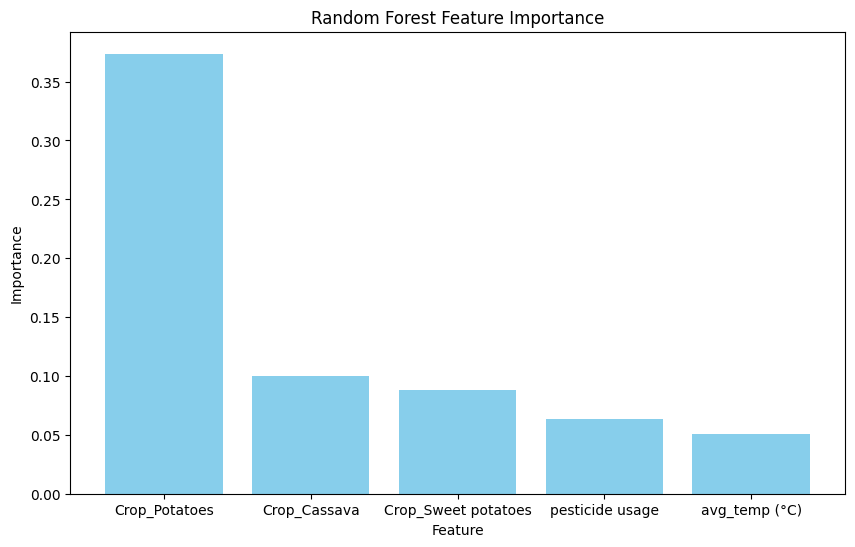

In [45]:
# Create a DataFrame to hold feature names and importances
df_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
df_importances = df_importances.sort_values(by='Importance', ascending=False).head(5)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(df_importances['Feature'], df_importances['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()

We can see from the feature importance plots that the top 5 imporant variables are crop_potatoes, crop_cassava, crop_sweet_potatoes, pesticide usage and finally avg_temp. This makes sense since the average yield of potatoes is seen increasing through the years by a great amount hence it is only obvious that it has a high feature importance.